In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import gc
import glob
import re
import lightgbm as gbm
from numba import jit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

plt.style.use('fivethirtyeight')

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Another data source
daily = pd.read_csv("D:/TAMUIDS/clean_daily_median.csv", 
                    parse_dates = ['Trip Start Timestamp'], 
                    index_col = 'Trip Start Timestamp')

In [3]:
print((daily.index.min(), daily.index.max()))

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-07-31 00:00:00'))


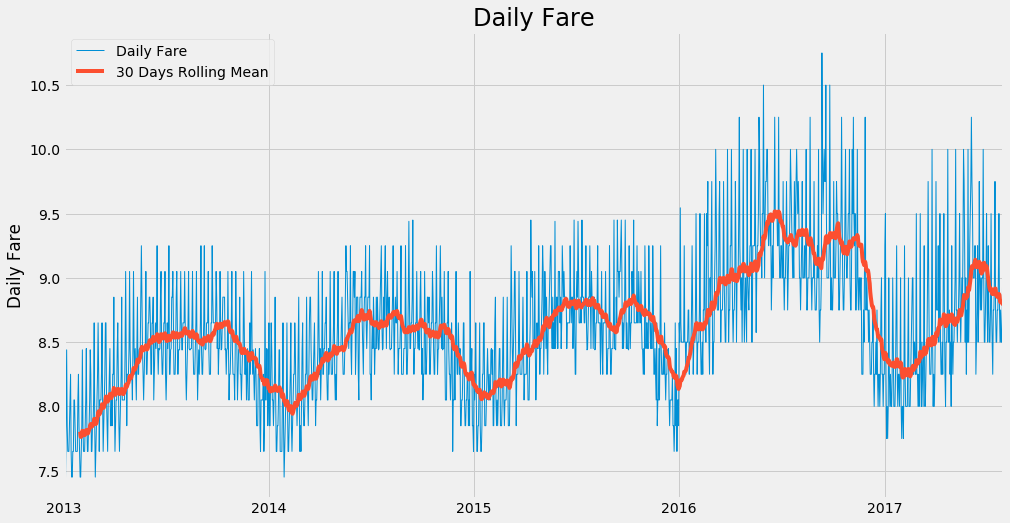

In [4]:
daily['Fare'].plot(figsize = (15, 8), linewidth = 1)
daily['Fare'].rolling(30).mean().plot()
plt.xlabel('')
plt.ylabel('Daily Fare')
plt.title('Daily Fare', fontsize = 24)
plt.legend(['Daily Fare', '30 Days Rolling Mean'])
plt.show()

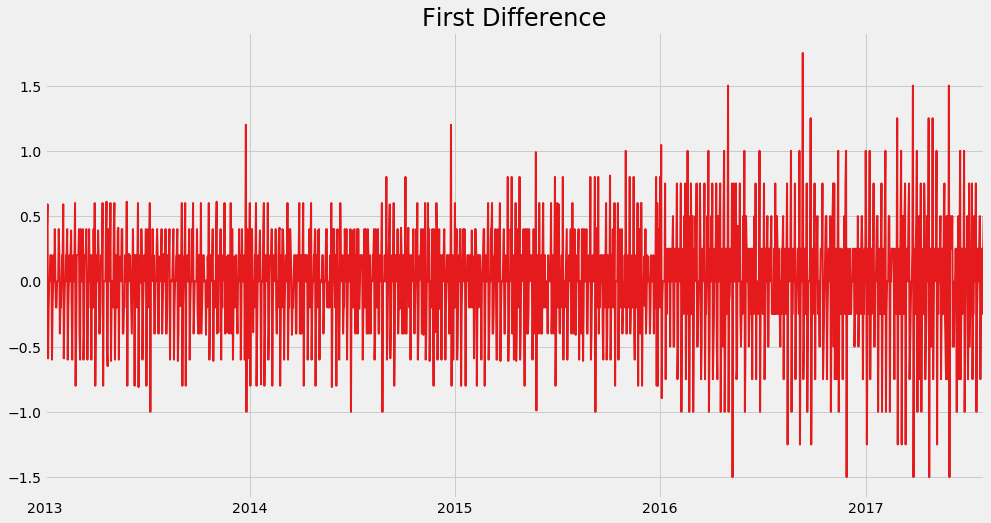

In [21]:
# First Difference on Fare
ax = daily.Fare.diff().plot(figsize = (15, 8), linewidth = 2, colormap = 'Set1')
ax.set_title("First Difference", fontsize = 24)
ax.set_xlabel("")
plt.show()

In [10]:
# Augmented Dickey-Fuller test
# A random walk with drift, especially from 2016 to 2017
print("Results of Aumented Dickey-Fuller Test")
result = adfuller(daily.Fare)
print("The p-value for the ADF test is ", result[1])
print()

dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Aumented Dickey-Fuller Test
The p-value for the ADF test is  0.05588212799865262

Test Statistic                   -2.817029
p-value                           0.055882
#Lags Used                       22.000000
Number of Observations Used    1650.000000
Critical Value (1%)              -3.434319
Critical Value (5%)              -2.863293
Critical Value (10%)             -2.567703
dtype: float64


In [11]:
#After first diff now it is stationary
result = adfuller(daily.Fare.diff().dropna())
print("Results of Aumented Dickey-Fuller Test")
print("The p-value for the ADF test is ", result[1])
print()

dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Aumented Dickey-Fuller Test
The p-value for the ADF test is  3.445579040659539e-23

Test Statistic                -1.245863e+01
p-value                        3.445579e-23
#Lags Used                     2.100000e+01
Number of Observations Used    1.650000e+03
Critical Value (1%)           -3.434319e+00
Critical Value (5%)           -2.863293e+00
Critical Value (10%)          -2.567703e+00
dtype: float64


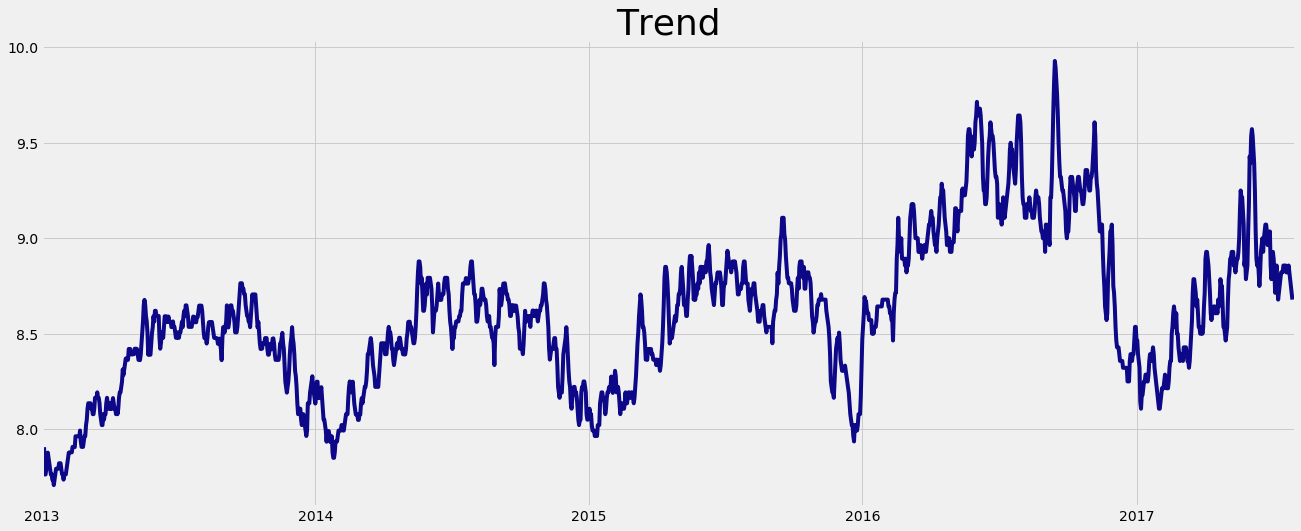

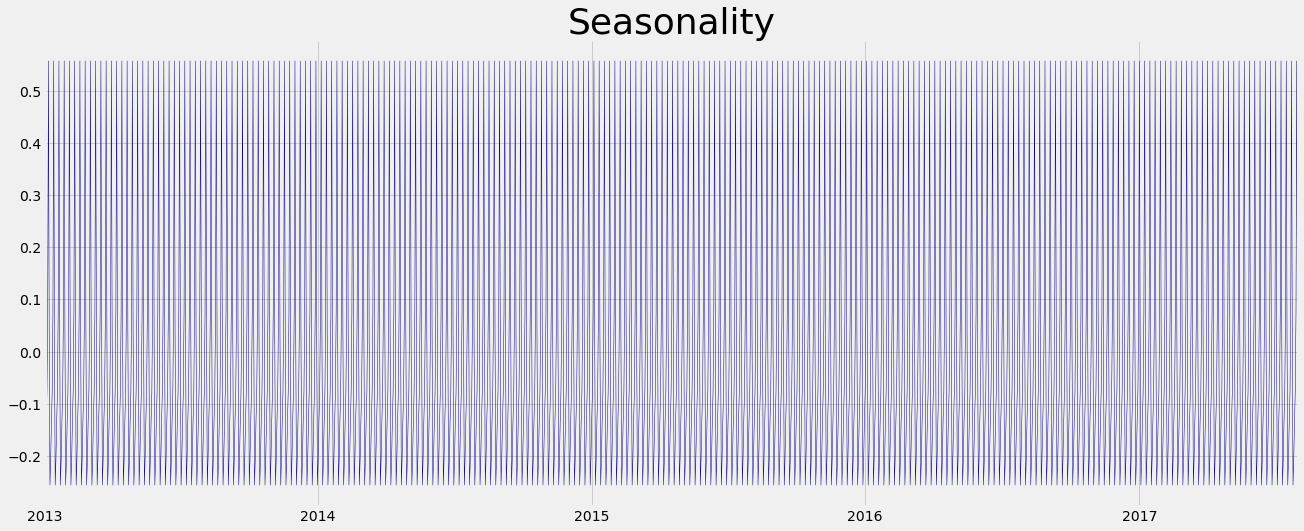

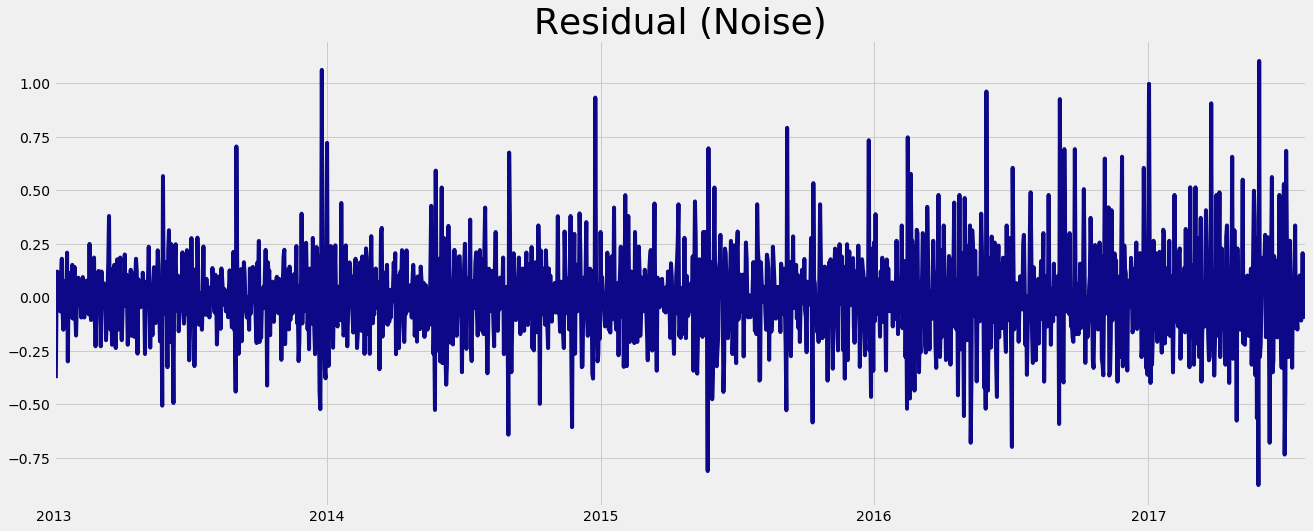

In [12]:
# Time Series Decomposition
decomposition = sm.tsa.seasonal_decompose(daily.Fare)

trend = decomposition.trend

ax = trend.plot(figsize = (20, 8), colormap='plasma')
ax.set_title('Trend', fontsize = 36)
ax.set_xlabel('')

plt.show()

ax2 = decomposition.seasonal.plot(figsize = (20, 8), linewidth = 0.5, colormap='plasma')
ax2.set_title('Seasonality', fontsize=36)
ax2.set_xlabel('')

plt.show()

ax3 = decomposition.resid.plot(figsize=(20, 8), colormap='plasma')
ax3.set_title('Residual (Noise)', fontsize = 36)
ax3.set_xlabel('')
plt.show()

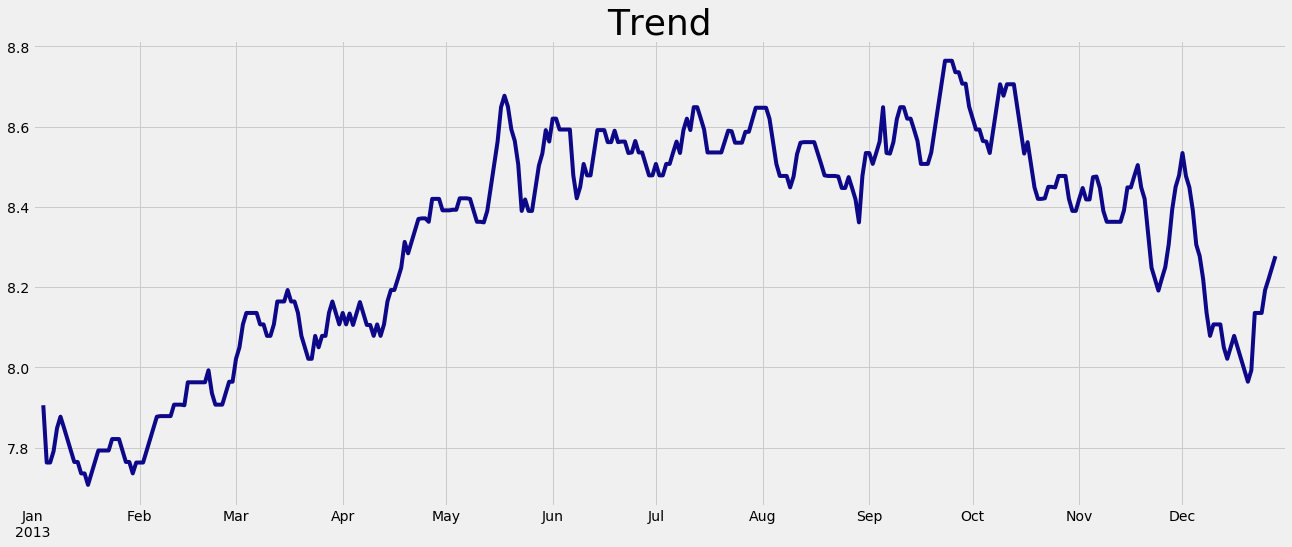

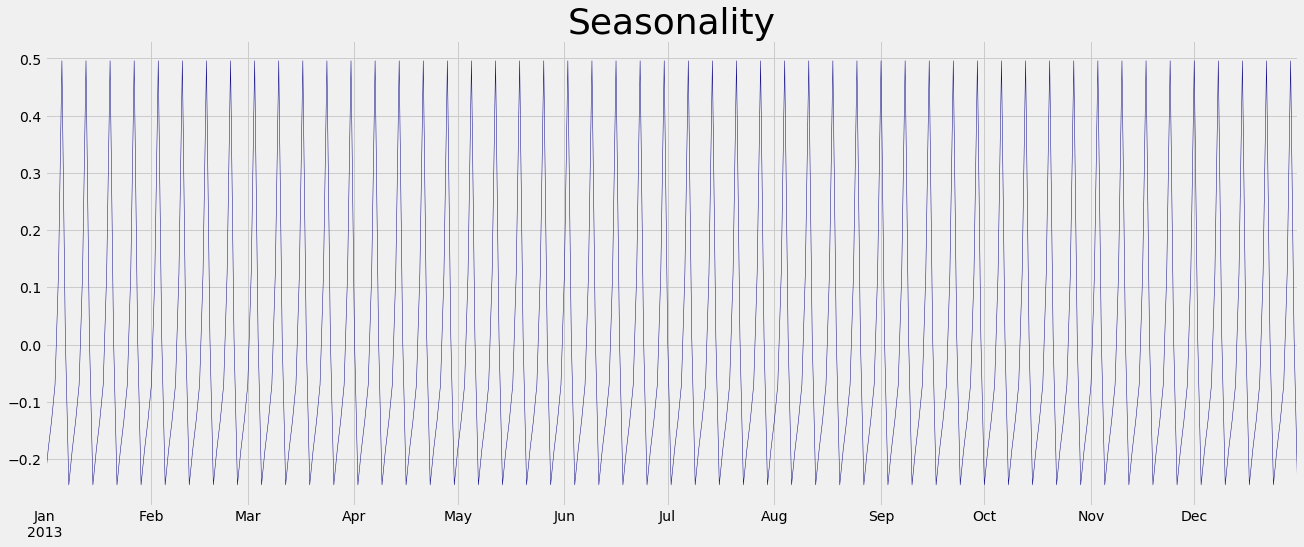

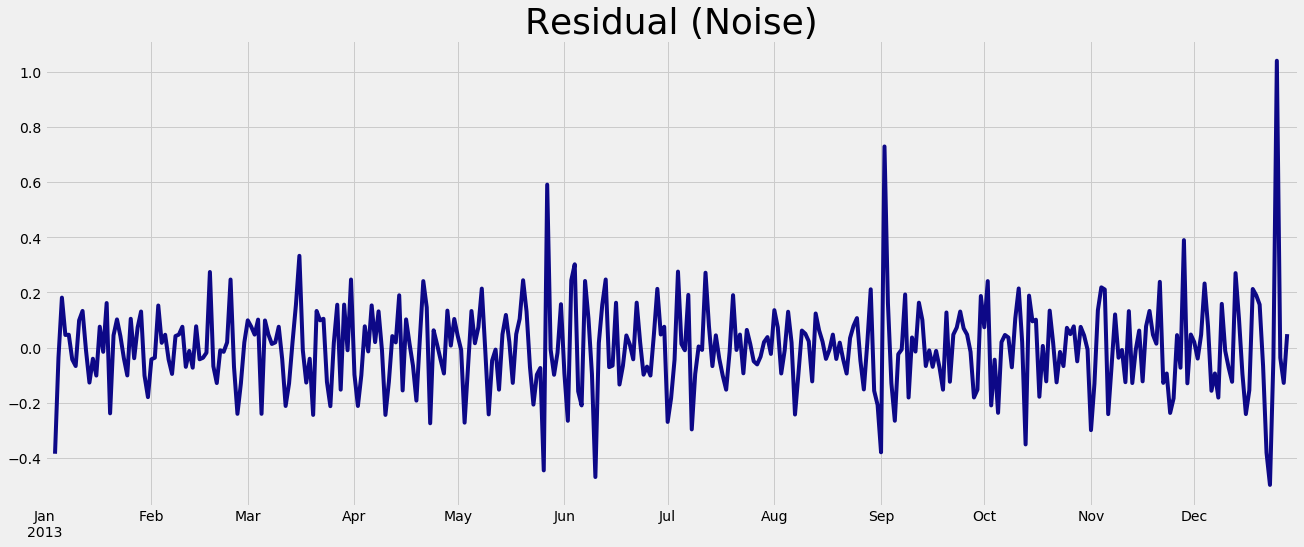

In [13]:
# Time Series Decomposition
decomposition = sm.tsa.seasonal_decompose(daily['2013'].Fare)

trend = decomposition.trend

ax = trend.plot(figsize = (20, 8), colormap='plasma')
ax.set_title('Trend', fontsize = 36)
ax.set_xlabel('')

plt.show()

ax2 = decomposition.seasonal.plot(figsize = (20, 8), linewidth = 0.5, colormap='plasma')
ax2.set_title('Seasonality', fontsize=36)
ax2.set_xlabel('')

plt.show()

ax3 = decomposition.resid.plot(figsize=(20, 8), colormap='plasma')
ax3.set_title('Residual (Noise)', fontsize = 36)
ax3.set_xlabel('')
plt.show()

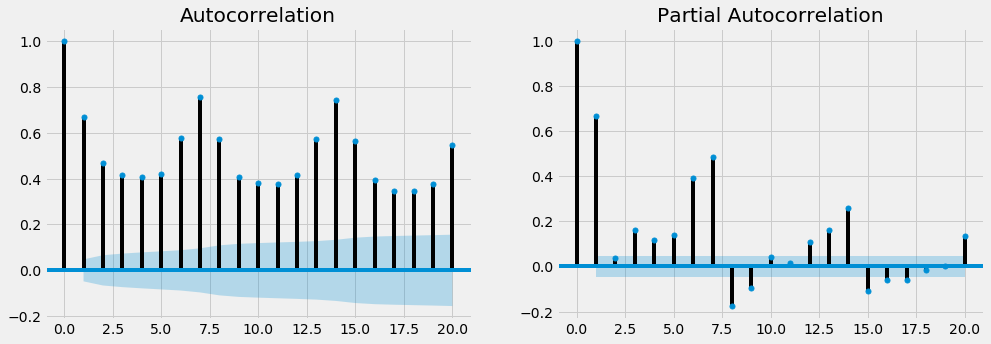

In [14]:
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(1,2, figsize = (15, 5))

# Plot the ACF
plot_acf(daily.Fare, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(daily.Fare, lags=20, ax=axes[1])
plt.show()

# Baseline Model ARIMA

In [20]:
BIC = []
AIC = []

params = [(2,1,1), (2,1,2), (2,1,3), (3,1,2), (4,1,2), (4,1,3), (4,1,4), (5,1,4), (5,1,5), (5,1,6), (6,1,4)]
for param in params:
    mod = ARIMA(daily.Fare['2013':'2016'], order=param)
    res = mod.fit()
    AIC.append(res.aic)
    BIC.append(res.bic)
    print('ARIMA{} - AIC:{}'.format(param, res.bic))

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


ARIMA(2, 1, 1) - AIC:938.980565376599
ARIMA(2, 1, 2) - AIC:894.1783585677404


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3) - AIC:925.7993308352784
ARIMA(3, 1, 2) - AIC:893.4197260895198
ARIMA(4, 1, 2) - AIC:660.5935456108849


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 3) - AIC:555.2319923488255


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 4) - AIC:548.6530384083032


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 1, 4) - AIC:447.0262397956168


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(5, 1, 5) - AIC:279.3399352391339


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 1, 6) - AIC:260.95158585287663
ARIMA(6, 1, 4) - AIC:465.9513274186343


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
pd.DataFrame({'Params' : params, 'AIC' : AIC, 'BIC' : BIC}, columns=['Params', 'AIC', 'BIC'])

,Params,AIC,BIC
0,"(2, 1, 1)",912.549607,938.980565
1,"(2, 1, 2)",862.461208,894.178359
2,"(2, 1, 3)",888.795989,925.799331
3,"(3, 1, 2)",856.416384,893.419726
4,"(4, 1, 2)",618.304012,660.593546
5,"(4, 1, 3)",507.656267,555.231992
6,"(4, 1, 4)",495.791121,548.653038
7,"(5, 1, 4)",388.878131,447.026240
8,"(5, 1, 5)",215.905635,279.339935
9,"(5, 1, 6)",192.231094,260.951586


In [15]:
mod = ARIMA(daily.Fare['2013':'2016'], order=(5,1,6))
res = mod.fit()
print("RMSE of the Best ARIMA Model: {}".format(sqrt(mean_squared_error(res.forecast(steps=212)[0], daily.Fare['2017'].values))))

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


RMSE of the Best ARIMA Model: 0.530587831839932


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


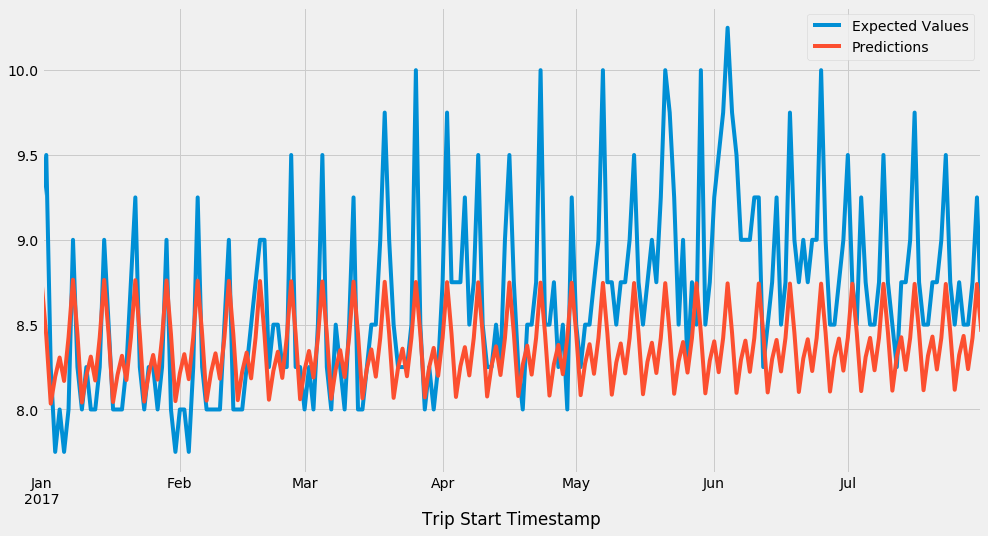

In [16]:
pd.DataFrame({'Predictions' : res.forecast(steps=212)[0], 'Expected Values' : daily.Fare['2017']}).plot(figsize=(15, 8))
plt.show()

In [4]:
print(len(daily['2013']), len(daily['2014']), len(daily['2015']), len(daily['2016']), len(daily['2017']))

365 365 365 366 212


In [42]:
"""
LSTM 
"""
np.random.seed(12345)
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# Pure Value
raw_values = daily.Fare.values
diff_values = difference(raw_values, 1)

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# Train 2013-2016 to forecast 2017
train, test = supervised_values[0:-212], supervised_values[-212:]

scaler, train_scaled, test_scaled = scale(train, test)

rmse_list = []
n_loop = 30
start_time = time.time()

for _ in range(n_loop):
    #print('{}th loop'.format(_))
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 50, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    # walk-forward validation on the test data
    predictions = list()

    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
        
    rmse = sqrt(mean_squared_error(raw_values[-212:], predictions))
    
    rmse_list.append(rmse)

print()
print("The Mean of LSTM Neural Network : {} std: {}".format(np.mean(rmse_list), np.std(rmse_list)))
print("\nThe whole process took {} mins".format((time.time() - start_time)/60))


The Mean of LSTM Neural Network : 0.45559513783315503 std: 0.01836523609622751

The whole process took 178.49847429593405 mins


In [43]:
rmse_df = pd.Series(rmse_list).to_frame()

rmse_df.describe()

,0
count,30.000000
mean,0.455595
std,0.018679
min,0.432438
25%,0.448482
50%,0.451258
75%,0.453920
max,0.520906


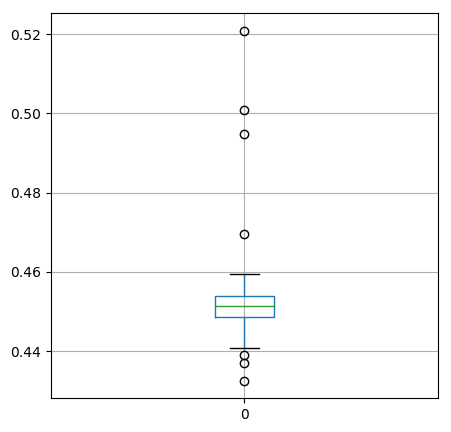

In [60]:
plt.style.use('default')
rmse_df.boxplot(figsize = (5,5))
plt.show()